In [1]:
import torch
import torchvision
import os
from torch import nn, optim
import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader,Dataset
import cv2
import random
from tqdm import tqdm
from threading import Thread
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class LoadData(Dataset):
    def __init__(self,path:str,transform:torchvision.transforms):
        self.path = path
        self.transform = transform
        self.class_to_idx = {}
        self.idx_to_class = {}
        self.X = []
        self.y = []
        self.clz_to_idx()
        self.load_images()
    
    def clz_to_idx(self):
        idx = -1
        for folder_name in os.listdir(self.path):
            idx += 1
            self.class_to_idx[folder_name] = idx
            self.idx_to_class[idx] = folder_name
    
    def load_images(self):
        for folder_name in tqdm(os.listdir(self.path)):
            for file in os.listdir(self.path + f"{folder_name}/"):
                if file != '.ipynb_checkpoints':
                    img = Image.open(self.path + f"{folder_name}/{file}")
                    img = self.transform(img)
                    Thread(target=self.X.append,args=[img]).start()
                    Thread(target=self.y.append,args=[self.class_to_idx[folder_name]]).start()
    
    def __getitem__(self,index):
        return (self.X[index],self.y[index])

    
    def __len__(self):
        return len(self.X)


In [3]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomGrayscale(p=0.125),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.TrivialAugmentWide(num_magnitue_bins=31),
    transforms.RandomRotation(random.randint(1,50)),
    transforms.GaussianBlur(3),
    transforms.ToTensor()
])

In [4]:
train_dataset = LoadData(path="data/seg_train/seg_train/",transform=train_transform)

100%|███████████████████████████████████████████████████████| 6/6 [03:22<00:00, 33.67s/it]


In [5]:
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [6]:
test_dataset = LoadData(path="data/seg_test/seg_test/",transform=test_transform)

100%|███████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.39s/it]


In [7]:
import random

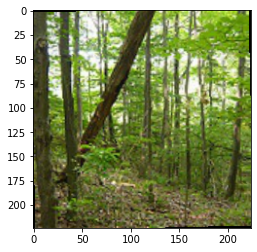

In [8]:
plt.imshow(train_dataset[random.randint(0,len(train_dataset))][0].permute(1,2,0))

In [9]:
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=round(os.cpu_count()/2))
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=round(os.cpu_count()/2))

In [10]:
no_classes = len(train_dataset.class_to_idx.values())

In [11]:
def loss_fn(model,criterion,dataloader):
    tot = 0
    no = 0
    model.eval()
    with torch.no_grad():
        for X,y in dataloader:        
            preds = model(X.to(device))
            loss = criterion(preds.to(device),y.to(device).long())
            tot += loss.item()
            no += 1
    model.train()
    return tot/no
def accuracy(model,dataloader):
    tot = 0
    no = 0
    model.eval()
    with torch.no_grad():
        for X,y in dataloader:
            tot_iter = 0
            cor_iter = 0
            preds = model(X.to(device))
            preds = torch.argmax(preds,dim=1)
            for pred,y_iter in zip(preds,y):
                tot_iter += 1
                if pred == y_iter:
                    cor_iter += 1
            no += 1
            tot += cor_iter/tot_iter
    model.train()
    return (tot/no)*100

In [12]:
class CNNModel(torch.nn.Module):
    def __init__(self,input_size:int,output_size:int) -> None:
        super().__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(input_size,8,kernel_size=2,stride=1,padding=2),
            nn.MaxPool2d(2), 
            nn.BatchNorm2d(8), 
            nn.ReLU()
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(8,16,kernel_size=2,stride=1,padding=2),
            nn.MaxPool2d(2), 
            nn.BatchNorm2d(16), 
            nn.ReLU(),
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=2,stride=1,padding=2),
            nn.AvgPool2d(2), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.Dropout()
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=2,stride=1,padding=2),
            nn.MaxPool2d(2), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=2,stride=1,padding=2),
            nn.MaxPool2d(2), 
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        self.linear1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*9*9,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.linear2 = nn.Sequential(
            nn.Linear(1024,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout()
        )
        self.linear3 = nn.Sequential(
            nn.Linear(2048,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.output = nn.Linear(1024,output_size)
    
    def forward(self,X) -> torch.tensor:
        y = self.convblock1(X)
        y = self.convblock2(y)
        y = self.convblock3(y)
        y = self.convblock4(y)
        y = self.convblock5(y)
        # print(y.shape)
        y = self.linear1(y)
        y = self.linear2(y)
        y = self.linear3(y)
        y = self.output(y)
        return y

In [13]:
model = CNNModel(3,no_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
# schdeular = optim.lr_scheduler.StepLR(optimizer,10,verbose=True)
epochs = 100

In [14]:
# model

In [ ]:
wandb.init(project='Intel Image Classification', name='Final', config={
"Model":"CNN",
"Lr":0.001,
"Optimizer":"Adam",
"Criterion":"CrossEntropyLoss()"
})
wandb.watch(model,criterion,log='all',log_graph=True)
for epoch in tqdm(range(epochs)):
    model.train()
    for X_batch,y_batch in train_dataloader:
        torch.cuda.empty_cache()
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        preds = model(X_batch)
        loss = criterion(preds,y_batch.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    wandb.log({
        "Accuracy Test":accuracy(model,test_dataloader),
        "Accuracy Train":accuracy(model,train_dataloader),
        "Loss Test":loss_fn(model,criterion,test_dataloader),
        "Loss Train":loss_fn(model,criterion,train_dataloader),
    })
    # schdeular.step()
wandb.save()
wandb.finish()

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
 52%|███████████████████████████                         | 52/100 [29:53<28:18, 35.39s/it]